In [89]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv

In [2]:
im_orig = np.array(Image.open("im04.jpg")).astype("double")

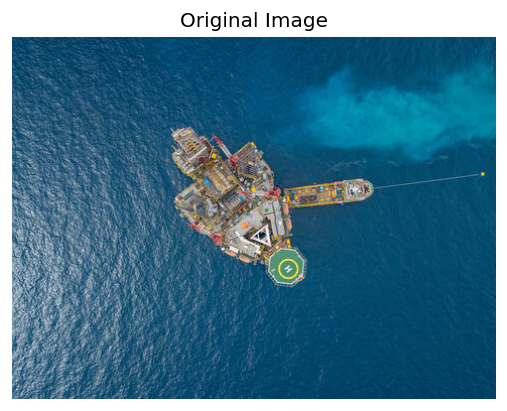

In [3]:
plt.figure(dpi=120)
plt.imshow(im_orig.astype("uint8"))
plt.axis("off")
plt.title("Original Image")
plt.show()

We first apply a gaussian filter in order to smoothen the image:

In [4]:
im_smooth = cv.GaussianBlur(im_orig,(7,7),cv.BORDER_DEFAULT)

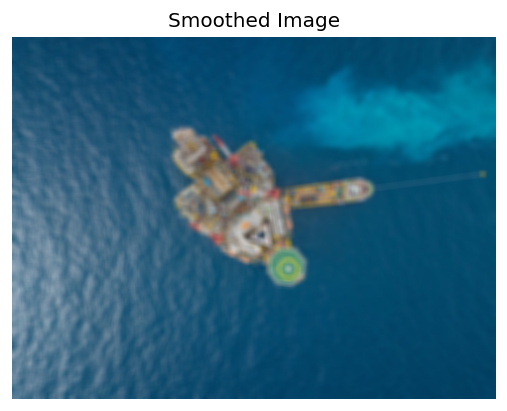

In [5]:
plt.figure(dpi=120)
plt.imshow(im_smooth.astype("uint8"))
plt.axis("off")
plt.title("Smoothed Image")
plt.show()

In [6]:
def gradient(im):
    sobelx = cv.Sobel(im, cv.CV_64F, 1, 0, ksize=3)
    sobely = cv.Sobel(im, cv.CV_64F, 0, 1, ksize=3)
    grad = (sobelx[:,:,0]**2 + sobely[:,:,0]**2 + sobelx[:,:,1]**2 + sobely[:,:,1]**2 + sobelx[:,:,2]**2 + sobely[:,:,2]**2)**0.5
    return grad

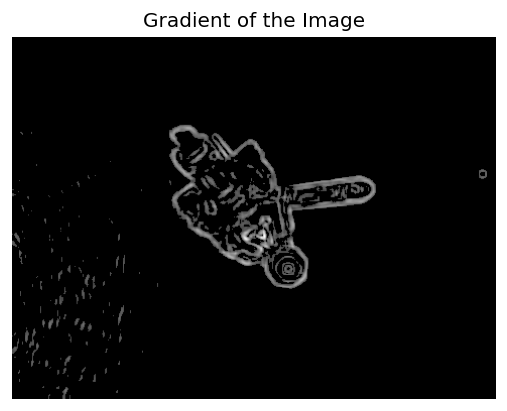

In [7]:
# I have applied a threshold to remove low gradients(which happen in the clouds at the top right of the image)
grad = gradient(im_smooth)
grad[grad<(27/100)*grad.max()] = 0
plt.figure(dpi=120)
plt.imshow(grad, cmap="gray")
plt.axis("off")
plt.title("Gradient of the Image")
plt.show()

In [8]:
def energy_calculator(gradient, v1, v2, alpha):
    '''This function gets the gradient matrix, two points and a constant alpha and returns the pair-wise energy of
    these two points'''
    x1, y1 = v1
    x2, y2 = v2
    G2 = gradient[x1, y1]**2
    energy = - G2 + alpha * ((x2-x1)**2 + (y2-y1)**2)
    return energy

In [9]:
def dynamic_programming(gradient, init_points, alpha):
    points_num = len(init_points)
    costs = np.zeros((9,points_num-1))
    path_arr = np.zeros((9,points_num))
    states_arr = np.zeros((9,points_num)).tolist()
    final_costs = np.zeros(9)
    for i in range(points_num):
        x,y = init_points[i]
        for k in range(9):
            x_diff = k//3 - 1
            y_diff = k%3 - 1
            states_arr[k][i] = (x + x_diff, y + y_diff)
    for i in range(points_num - 1):
        current_index = i
        next_index = i + 1
        for j in range(9):
            min_cost = 10000000
            min_k = 0
            for k in range(9):
                v2 = states_arr[j][next_index]
                v1 = states_arr[k][current_index]
                cost = energy_calculator(gradient, v1, v2, alpha)
                if (cost < min_cost):
                    min_k = k
                    min_cost = cost
            if (current_index == 0):
                costs[j, current_index] = min_cost
            else:
                costs[j, current_index] = min_cost + costs[min_k, current_index - 1]
            path_arr[j, current_index] = min_k
    # finding the starting point of each endpoint
    for i in range(9):
        previous_state = i
        for j in range(points_num-1,-1,-1):
            previous_state = int(path_arr[previous_state, j])
        first_state = previous_state
        v2 = states_arr[first_state][0]
        v1 = states_arr[i][points_num - 1]
        cost = energy_calculator(gradient, v1, v2, alpha)
        final_costs[i] = costs[i, points_num - 2] + cost
    final_state = np.argmin(final_costs)
    points = [states_arr[final_state][points_num - 1]]
    for j in range(points_num - 2, -1, -1):
        final_state = int(path_arr[final_state, j])
        points.append(states_arr[final_state][j])
    return points[::-1], path_arr, costs

In [30]:
def initial_point_finder(corner1, corner2, corner3, corner4, between_corner = 5):
    points = []
    for i in range(between_corner):
        x1, y1 = corner1
        x2, y2 = corner2
        points.append((int(x1 + (x2 - x1)/between_corner * i), int(y1 + (y2 - y1)/between_corner * i)))
    for i in range(between_corner):
        x1, y1 = corner2
        x2, y2 = corner3
        points.append((int(x1 + (x2 - x1)/between_corner * i), int(y1 + (y2 - y1)/between_corner * i)))
    for i in range(between_corner):
        x1, y1 = corner3
        x2, y2 = corner4
        points.append((int(x1 + (x2 - x1)/between_corner * i), int(y1 + (y2 - y1)/between_corner * i)))
    for i in range(between_corner):
        x1, y1 = corner4
        x2, y2 = corner1
        points.append((int(x1 + (x2 - x1)/between_corner * i), int(y1 + (y2 - y1)/between_corner * i)))
    return points

In [39]:
def point_drawer(im, points, color=(0,255,0), radius=3):
    out = im.copy()
    for point in points:
        out = cv.circle(out, (point[1], point[0]), radius, color, -1)
    return out.astype("uint8")

In [84]:
def active_contour(im, grad, alpha, max_iter=100):
    init_points = initial_point_finder((80, 155), (80, 360), (260, 360), (260, 155))
    Image.fromarray(point_drawer(im, init_points).astype("uint8")).save("results/q3/im0.jpg", "JPEG")
    final_iter = max_iter 
    for i in range(1,max_iter + 1):
        new_points, path_arr, costs = dynamic_programming(grad, init_points, alpha)
        if (new_points == init_points):
            final_iter = i
            break
        else:
            init_points = new_points
            Image.fromarray(point_drawer(im, init_points).astype("uint8")).save("results/q3/im"+str(i)+".jpg", "JPEG")
    if (final_iter == max_iter):
        print("Maximum Number of Iterations Reached!")
    else:
        print("The process was done in " + str(i) + " iterations!")
    return point_drawer(im,init_points)

In [87]:
# I changed the alpha and I found that the best value is around 38
final_image = active_contour(im_orig, grad, 23)

The process was done in 90 iterations!


In [91]:
os.system('ffmpeg -start_number 0 -i results/q3/im%d.jpg -r 90 -vcodec mpeg4 results/res13-contour.mp4')

0